In [871]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

pd.options.plotting.backend = 'plotly'

In [872]:
#df = pd.read_csv('data_mesh/20220719_Levoit400s_4_spd.c.csv')
#df = pd.read_csv('data_mesh/20220720_GermGuardian_CDAP4500BCA_5_spd.a.csv')
#df = pd.read_csv('pms5003/data_smoke/20220707b_Levoit400s_4_spd.csv')
#df = pd.read_csv('data_mesh/20220809c_Levoit400s_4_spd.csv')
#df = pd.read_csv('data_mesh/20220805a_Levoit400s_4_spd_ACon.csv')
#df = pd.read_csv('data_mesh/20220805c_GermGuardian_CDAP4500BCA_5_spd.csv')
#df = pd.read_csv('data_mesh/20220807c_5_ArcticP14_4_Starkvind_100_pwr.csv')
#df = pd.read_csv('data_mesh/20220806b_GermGuardian_CDAP4500BCA_5_spd.csv')
#df = pd.read_csv('data_mesh/20220806a_GermGuardian_AC4825W_3_spd.csv')
#df = pd.read_csv('data_mesh/20220808e_LaskoB20201_4_Filtrete1900_2_spd.csv')
#df = pd.read_csv('data_mesh/20220809c_2_iPPC3000_2_Starkvind_2000_rpm.csv')
#df = pd.read_csv('data_incense/20220825c_SilverStoneAP182_4_isinlive_LVH128_2000rpm.csv')
#df = pd.read_csv('data_mesh/20220825c_SilverStoneAP182_4_isinlive_LVH128_1200rpm.csv')
#df = pd.read_csv('data_mesh/20220826b_SilverStoneAP182_4_isinlive_LVH128_nocharcoal_2000rpm.csv')
df = pd.read_csv('data_mesh/20220830b_Vornado660_3_Filtrete2200_spd2.csv')

# column to fit on, mass PM2.5 is a good choice for NaCl aerosol CADR
# changing this variable makes it possible to explore other options
col_fit = 'pm2.5'

# get rid of all the columns not used to fit the data
for col in [x for x in df.columns.values.tolist() if x not in [col_fit, 'time']]:
    del df[col]

# plot the original data
df.set_index('time').plot(title='SDS011', kind='line')

Look at the graph and select a time towards the end of the natural decay period for `user_selected_stop_time`

In [873]:
user_selected_stop_time = 1020

Optionally select a start time. Set to `None` to auto-detect. Can be useful if there is a false peak due to sensor saturation or the chamber had to be opened to stop particle generation.

In [874]:
user_selected_start_time = None

In [875]:
# see equation (S1) from supplemental material here: https://www.tandfonline.com/doi/full/10.1080/02786826.2022.2054674?scroll=top&needAccess=true
# version of the functions where ACH is unknown and has to be solved for
class DecayFuncs:
    def __init__(self, C_bgd, C_pt0):
        ## logarithmic function
        def func(t, ACH):
            # divide by 3600 to convert seconds to hours
            return C_bgd + C_pt0 * np.exp(-ACH*t / 3600)

        def linear_func(t, ACH):
            return np.log(C_pt0) - ACH * t / 3600

        self.func = func
        self.linear_func = linear_func

def test_fit(df):
    C_bgd = 0
    C_pt0 = df['pm2.5'][df.index[0]]
    f = DecayFuncs(C_bgd, C_pt0)

    popt, pcov = curve_fit(f.linear_func, df.time, np.log(df[col_fit]))
    stderr = np.sqrt(np.diag(pcov)[0])
    return (C_pt0, popt, stderr)

Find ACH_vd for this run based on the natural decay period.

C_pt0: 998.7
ACH_vd: 2.3702633196513885
stderr: 0.0024333842918865135


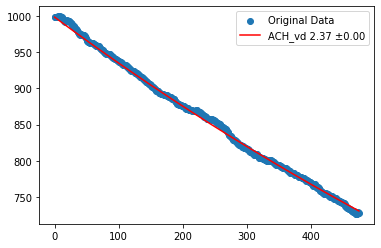

In [876]:
# find ACH_vd for this run
df_vd = df.copy()

pm25_max_idx = df_vd.idxmax()[col_fit]
start_time = df_vd.time[pm25_max_idx] + 60
if user_selected_start_time is not None:
    start_time = user_selected_start_time
start_time_idx = df_vd[df_vd.time >= start_time].index[0]
df_vd = df_vd.tail(-start_time_idx).copy()
df_vd.index -= df_vd.index[0]
time_offset = df_vd.time[0]
df_vd['time'] -= time_offset

# cut off all records before pm2.5 reached < 999.9
drop_start_idx = df_vd[df_vd[col_fit] < 999.9].index[0]
if drop_start_idx != 0:
    df_vd = df_vd.tail(-drop_start_idx).copy()
    df_vd.index -= df_vd.index[0]
    time_offset += df_vd.time[0]
    df_vd['time'] -= df_vd.time[0]

# end before the air purifier turns on
# for now just user-select based on time
time_stop = user_selected_stop_time - time_offset
# cut off all records after time reached user selected time
drop_start_idx = df_vd[df_vd.time >= time_stop].index[0]
if drop_start_idx != 0:
    df_vd = df_vd.head(drop_start_idx).copy()
    df_vd.index -= df_vd.index[0]
    df_vd['time'] -= df_vd.time[0]

C_pt0, popt, stderr = test_fit(df_vd)
ACH_vd = popt[0]
print('C_pt0: {}'.format(C_pt0))
print('ACH_vd: {}'.format(ACH_vd))
print('stderr: {}'.format(stderr))

f = DecayFuncs(0, C_pt0)

plt.scatter(df_vd.time, df_vd[col_fit], label="Original Data")
plt.plot(df_vd.time, f.func(df_vd.time, ACH_vd), 'r-', label="ACH_vd {:0.2f} ±{:0.2f}".format(ACH_vd, stderr))
plt.legend()


In [877]:
# begin window search at pm2.5 max
pm25_max_idx = df.idxmax()[col_fit]
if pm25_max_idx != 0:
    df = df.tail(-pm25_max_idx).copy()
    df.index -= df.index[0]
    df['time'] -= df.time[0]

drop_start_idx = df[df[col_fit] <= 500].index[0]
if drop_start_idx != 0:
    df = df.tail(-drop_start_idx).copy()
    df.index -= df.index[0]
    df['time'] -= df.time[0]

# trim all values below 100, error stops being multiplicative below there
lt25_iloc = df[df[col_fit] < 100].index[0]
df = df.head(lt25_iloc).copy()

print('num data points to fit: {}'.format(len(df)))

C_pt0, popt, stderr = test_fit(df)
ACH = popt[0]
print('C_pt0: {}'.format(C_pt0))
print('ACH: {}'.format(ACH))
print('stderr: {}'.format(stderr))

f = DecayFuncs(0, C_pt0)


num data points to fit: 60
C_pt0: 495.7
ACH: 94.877745314978
stderr: 0.2905010242395619


In [878]:
df.set_index('time').plot(kind='line')

For this next part don't forget to change V_r (Volume of room/chamber) to match your value.

stderr (ACH): 0.2905010242395619


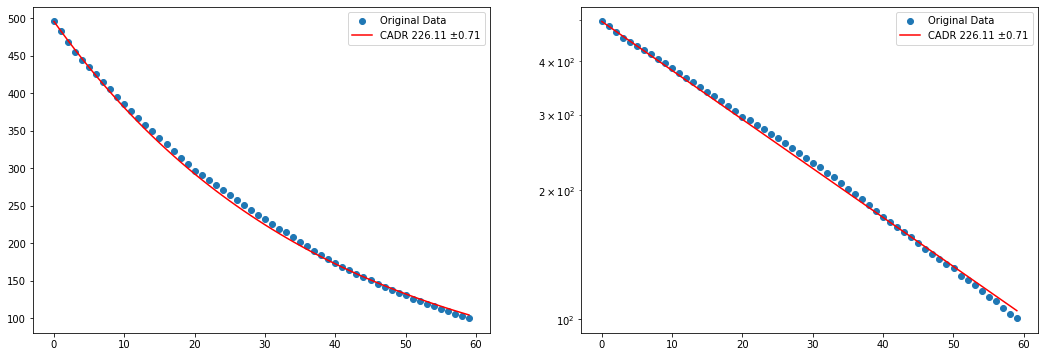

In [879]:
ACH_f = ACH - ACH_vd
# volume of room
V_r = (59. / 12) * (59. / 12) * (72.8 / 12) # this is in cubic feet
CADR = V_r * ACH_f / 60 # units of ACH are 1/h, divide by 60 to convert to 1/minutes so CADR is in cubic feet per minute
CADR_err = V_r * stderr / 60

print('stderr (ACH): {}'.format(stderr))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

plt.subplot(121)
plt.scatter(df.time, df[col_fit], label="Original Data")
plt.plot(df.time, f.func(df.time, ACH), 'r-', label="CADR {:0.2f} ±{:0.2f}".format(CADR, CADR_err))
plt.legend()

plt.subplot(122)
plt.scatter(df.time, df[col_fit], label="Original Data")
plt.plot(df.time, f.func(df.time, ACH), 'r-', label="CADR {:0.2f} ±{:0.2f}".format(CADR, CADR_err))
plt.yscale('log')
plt.legend()
#fig.suptitle('SDS011 Trial 5')
plt.show()